
# Forecast

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Concatenate, \
                                    LSTM, Activation, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow_addons.layers import SpectralNormalization as SN

In [2]:
%matplotlib inline
file_name = 'forecast_dublu_lstm'
dir_name = file_name + '_dir'
ckpt_dir = dir_name + '/ckpt'
os.mkdir(dir_name)
os.mkdir(ckpt_dir)

In [3]:
data = np.load('../../data/processed/normalized_generated_data.npz')
gen_electrical_data = data['electrical_data']
gen_labels = data['labels']

In [4]:
data = np.load('../../data/processed/full_data.npz')
electrical_data = data['electrical_data'][:500]
labels = data['labels'][:500]

## Split Data

In [5]:
def split_data(data, labels):
    train_factor, val_factor = 0.8, 0.1
    train_limit, val_limit = int(len(data) * train_factor), int(len(data) * (train_factor + val_factor))
    train_data, train_labels = data[:train_limit], labels[:train_limit]
    val_data, val_labels = data[train_limit:val_limit], labels[train_limit:val_limit]
    test_data, test_labels = data[val_limit:], labels[val_limit:]
    return train_data, train_labels, val_data, val_labels, test_data, test_labels

In [6]:
train_data, train_labels, val_data, val_labels, test_data, test_labels = split_data(electrical_data, labels)
gen_train_data, gen_train_labels, gen_val_data, gen_val_labels, gen_test_data, gen_test_labels = split_data(gen_electrical_data, gen_labels)

## Building the Model

In [7]:
early_stopping_monitor = EarlyStopping(patience=3)
data_length = 720 # One month of data
nr_labels = 6 # from labels + timestamp
emb_input_dim = 28 + electrical_data.shape[1] - data_length + 1 # Added values are for timestamp
emb_output_dim = 32
batch_size = 128

In [8]:
def conv_block(kernel_size, filters, padding, input_layer):
    sn_conv_1d = SN(Conv1D(kernel_size=kernel_size, filters=filters, padding=padding))(input_layer)
    bn = BatchNormalization()(sn_conv_1d)
    act = Activation('relu')(bn)
    mp_1d = MaxPooling1D()(act)
    res = Dropout(0.2)(mp_1d)
    return res

In [11]:
def create_model():
    sampled_data = Input((data_length, electrical_data.shape[2]), name='input_1')
    sampled_labels = Input((nr_labels,), name='input_2')
    label_embedding = SN(Embedding(emb_input_dim, emb_output_dim, input_length=nr_labels))(sampled_labels)
    flatten_embedding = Flatten()(label_embedding)
    dense_embedding = SN(Dense(64))(flatten_embedding)
    conv1 = conv_block((3), 128, 'same', sampled_data)
    conv2 = conv_block((5), 128, 'same', sampled_data)
    conv3 = conv_block((7), 128, 'same', sampled_data)
    conc_convs = Concatenate(axis=-1)([conv1, conv2, conv3])
    lstm1 = LSTM(128, return_sequences=True)(conc_convs)
    bn1 = BatchNormalization()(lstm1)
    lstm2 = LSTM(128)(bn1)
    bn2 = BatchNormalization()(lstm2)
    conc_all = Concatenate(axis=1)([bn2, dense_embedding])
    dense_final = SN(Dense(128, activation='relu'))(conc_all)
    res = SN(Dense(1, activation='tanh'))(dense_final)
    model = Model([sampled_data, sampled_labels], res, name='C-RNN')
    model.compile(optimizer = Adam(1e-3, 0.5, 0.9), loss = 'mse', metrics = ['mae', 'mape'])
    return model

## Define Generator

In [12]:
def generator_wrapper(data, labels, batch_size):
    def generator():
        while True:
            indexes = np.random.randint(0, data.shape[0], batch_size)
            sampled_data = data[indexes]
            hours = np.random.randint(0, data.shape[1] - data_length, batch_size)
            X = np.array([x[h:h + data_length] for x, h in zip(sampled_data, hours)])
            y = np.array([x[h + data_length, 0] for x, h in zip(sampled_data, hours)])
            l = np.array([np.concatenate((l, h), axis=-1) for l, h in zip(labels[indexes], np.expand_dims(hours, -1))])
            yield {'input_1': X, 'input_2': l}, y
    return generator

## Define Dataset

In [13]:
def dataset_from_generator(data, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(generator_wrapper(data, labels, batch_size), output_signature=\
                                             ({'input_1': tf.TensorSpec(shape=(batch_size, data_length, 6), dtype=tf.float64), \
                                              'input_2': tf.TensorSpec(shape=(batch_size, nr_labels), dtype=tf.int32)}, \
                                              tf.TensorSpec(shape=(batch_size), dtype=tf.float64)))
    #dataset = dataset.batch(batch_size)
    return dataset

## Trainging the Model

In [14]:
model = create_model()
history = model.fit(dataset_from_generator(train_data, train_labels, batch_size), epochs=100, steps_per_epoch=200, \
                    validation_data=dataset_from_generator(val_data, val_labels, batch_size), validation_steps=50, \
                    callbacks=[early_stopping_monitor])

Epoch 1/100
200/200 [==============================] - 37s 142ms/step - loss: 0.0427 - mae: 0.1479 - mape: 2105.5618 - val_loss: 0.1138 - val_mae: 0.2740 - val_mape: 44724.6836
Epoch 2/100
200/200 [==============================] - 27s 134ms/step - loss: 0.0134 - mae: 0.0877 - mape: 24147.5960 - val_loss: 0.0486 - val_mae: 0.1824 - val_mape: 15471.1758
Epoch 3/100
200/200 [==============================] - 27s 135ms/step - loss: 0.0097 - mae: 0.0728 - mape: 8121.8434 - val_loss: 0.0118 - val_mae: 0.0846 - val_mape: 4515.0640
Epoch 4/100
200/200 [==============================] - 27s 136ms/step - loss: 0.0087 - mae: 0.0689 - mape: 2864.1009 - val_loss: 0.0096 - val_mae: 0.0724 - val_mape: 7675.5513
Epoch 5/100
200/200 [==============================] - 27s 135ms/step - loss: 0.0081 - mae: 0.0659 - mape: 3513.6304 - val_loss: 0.0053 - val_mae: 0.0530 - val_mape: 103.7531
Epoch 6/100
200/200 [==============================] - 27s 136ms/step - loss: 0.0073 - mae: 0.0629 - mape: 12761.3141 

In [15]:
gen_model = create_model()
gen_history = gen_model.fit(dataset_from_generator(gen_train_data, gen_train_labels, batch_size), epochs=100, steps_per_epoch=200, \
                    validation_data=dataset_from_generator(gen_val_data, gen_val_labels, batch_size), validation_steps=50, \
                    callbacks=[early_stopping_monitor])

Epoch 1/100
200/200 [==============================] - 31s 138ms/step - loss: 0.0560 - mae: 0.1580 - mape: 221.9698 - val_loss: 0.1648 - val_mae: 0.3342 - val_mape: 296.1420
Epoch 2/100
200/200 [==============================] - 27s 135ms/step - loss: 0.0088 - mae: 0.0701 - mape: 79.3627 - val_loss: 0.0719 - val_mae: 0.2237 - val_mape: 90.7543
Epoch 3/100
200/200 [==============================] - 27s 133ms/step - loss: 0.0061 - mae: 0.0580 - mape: 72.1951 - val_loss: 0.0227 - val_mae: 0.1086 - val_mape: 111.3578
Epoch 4/100
200/200 [==============================] - 27s 134ms/step - loss: 0.0048 - mae: 0.0519 - mape: 123.2065 - val_loss: 0.0074 - val_mae: 0.0677 - val_mape: 78.2420
Epoch 5/100
200/200 [==============================] - 27s 134ms/step - loss: 0.0047 - mae: 0.0515 - mape: 405.1562 - val_loss: 0.0027 - val_mae: 0.0379 - val_mape: 55.3800
Epoch 6/100
200/200 [==============================] - 27s 133ms/step - loss: 0.0042 - mae: 0.0480 - mape: 48.1375 - val_loss: 0.0035 -

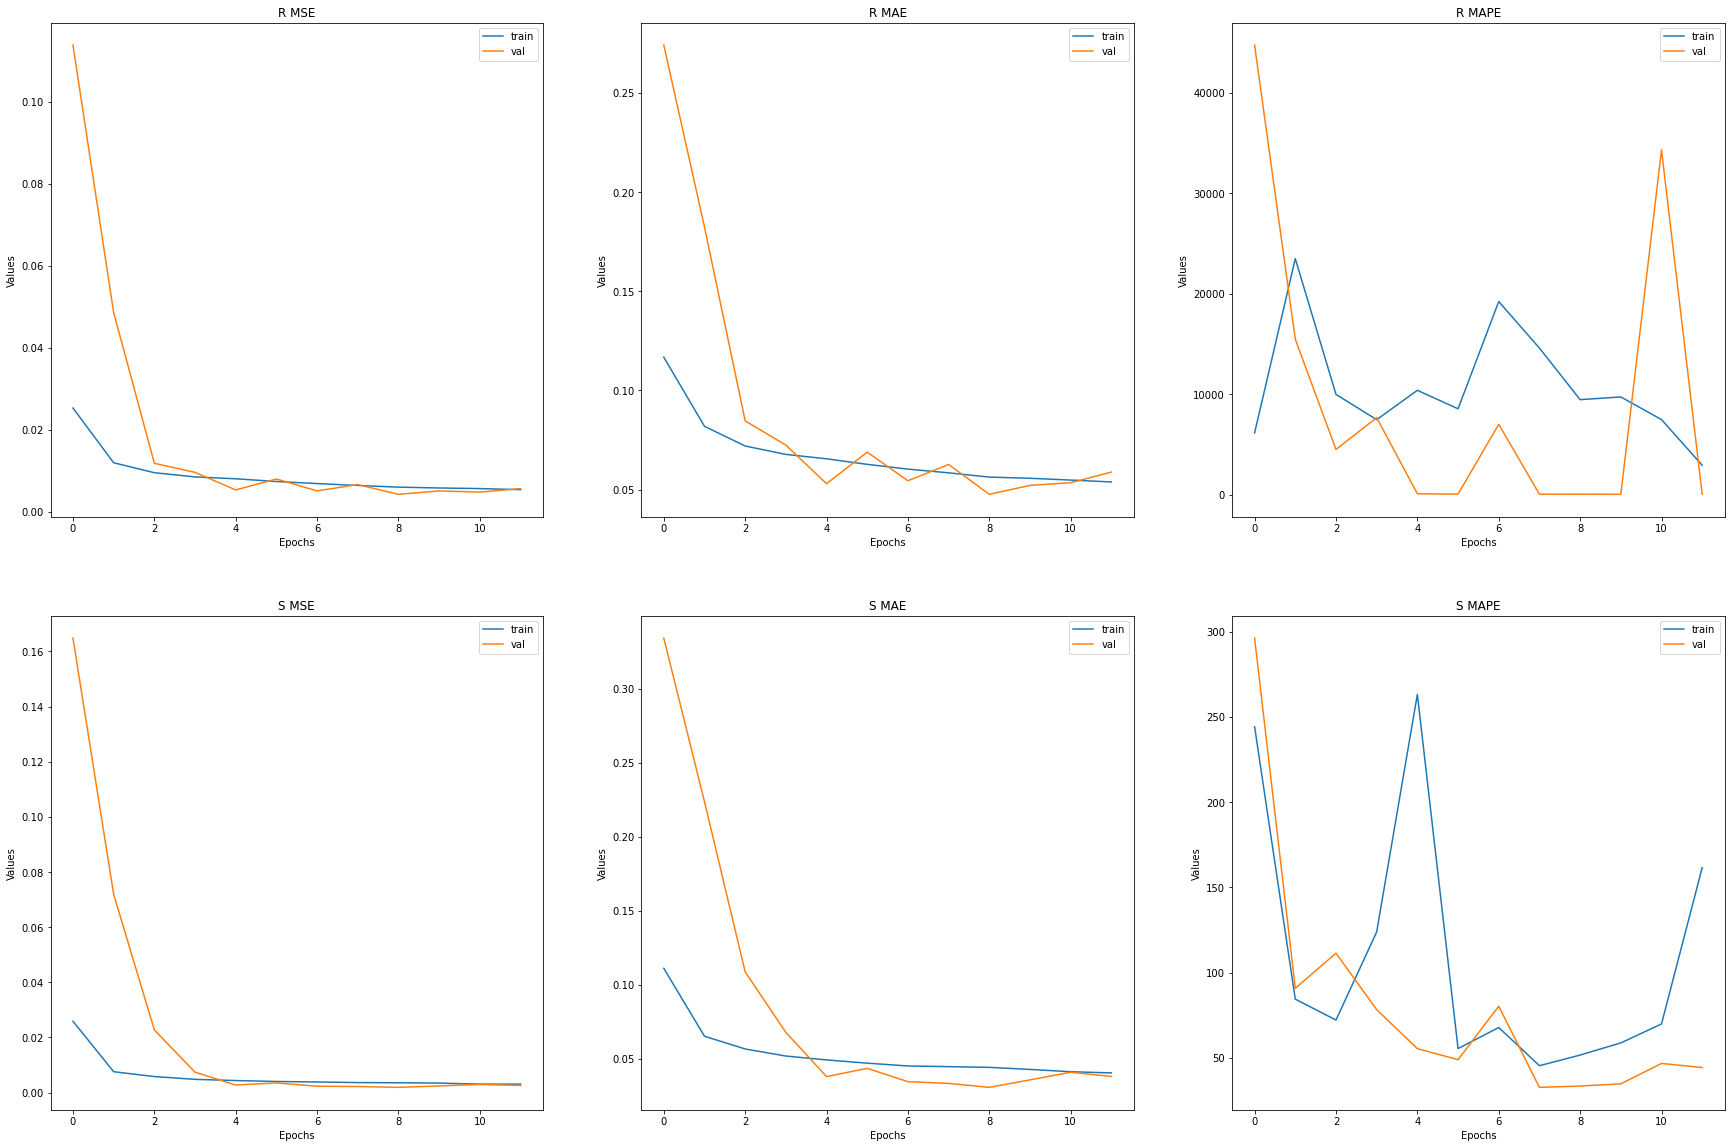

In [16]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(30, 20)
for i, his in enumerate([history, gen_history]):
    h = his.history
    data_type = 'R ' if i == 0 else 'S '
    for j, metric in enumerate(['loss', 'mae', 'mape']):
        title = metric if metric != 'loss' else 'mse'
        ax = axs[i, j]
        ax.plot(h[metric], label='train')
        ax.plot(h['val_' + metric], label='val')
        ax.title.set_text(data_type + title.upper())
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Values')
        ax.legend(loc="upper right")

In [17]:
model.save_weights(ckpt_dir + '/weights.ckpt')
gen_model.save_weights(ckpt_dir + '/gen_weights.ckpt')

## Test the Model

### TRTR

In [35]:
model_eval = model.evaluate(dataset_from_generator(test_data, test_labels, batch_size), steps=1000)

1000/1000 [==============================] - 51s 51ms/step - loss: 0.0051 - mae: 0.0559 - mape: 532.1181


### TRTS

In [39]:
model_eval_on_gen = model.evaluate(dataset_from_generator(gen_test_data, gen_test_labels, batch_size), steps=1000)

1000/1000 [==============================] - 50s 50ms/step - loss: 0.0098 - mae: 0.0775 - mape: 92.7751


### TSTR

In [31]:
gen_model_eval = gen_model.evaluate(dataset_from_generator(test_data, test_labels, batch_size), steps=1000)

1000/1000 [==============================] - 51s 51ms/step - loss: 0.0076 - mae: 0.0643 - mape: 183.4616


### TSTS

In [21]:
gen_model_eval_on_gen = gen_model.evaluate(dataset_from_generator(gen_test_data, gen_test_labels, batch_size), steps=1000)

1000/1000 [==============================] - 53s 53ms/step - loss: 0.0026 - mae: 0.0384 - mape: 42.6682


In [22]:
np.savez_compressed(dir_name + '_metrics&evals.npz', mse=history.history['loss'], mae=history.history['mae'], \
                    mape=history.history['mape'], gen_mse=gen_history.history['loss'], gen_mae=gen_history.history['mae'], \
                    gen_mape=gen_history.history['mape'], trtr=model_eval, trts=model_eval_on_gen, tstr=gen_model_eval, \
                    tsts=gen_model_eval_on_gen)

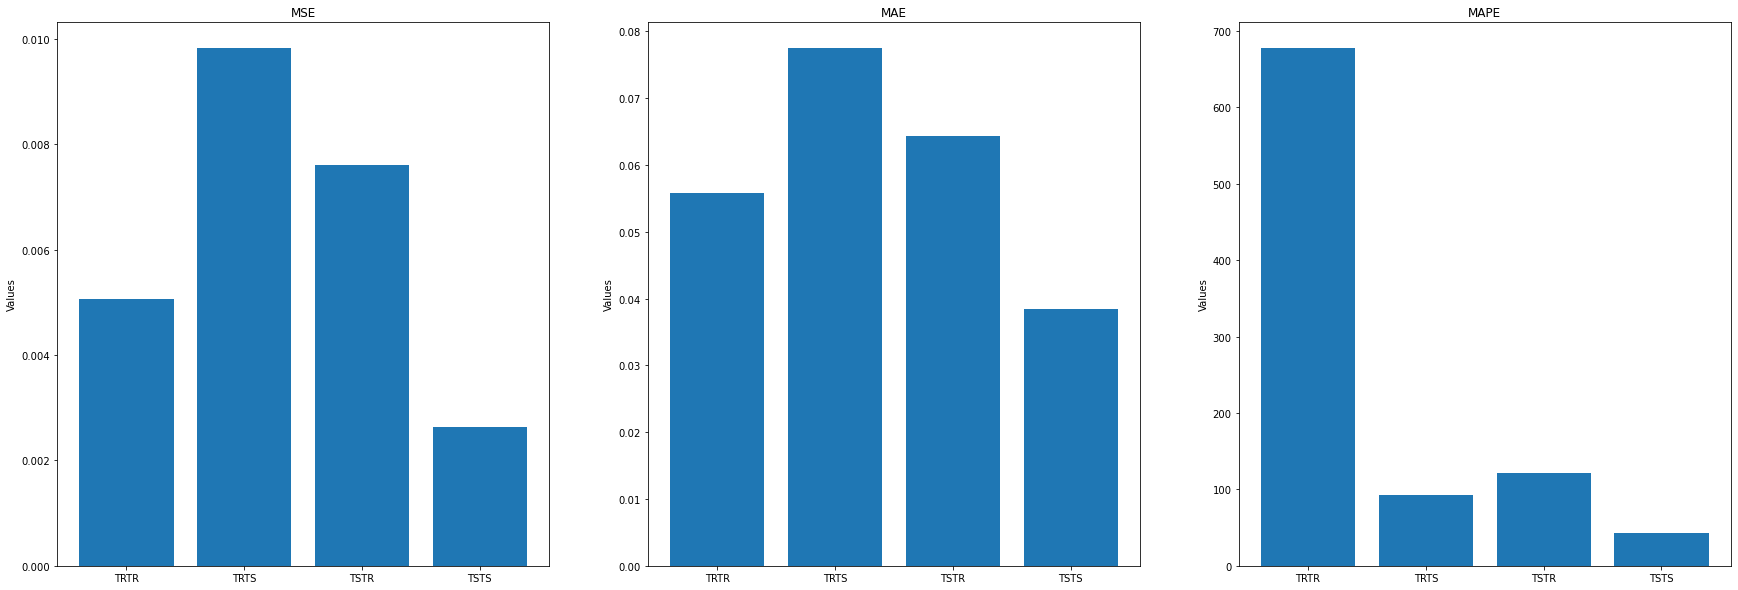

In [44]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(30, 10)
for i, metric in enumerate(['loss', 'mae', 'mape']):
    title = metric if metric != 'loss' else 'mse'
    ax = axs[i]
    ax.bar(['TRTR', 'TRTS', 'TSTR', 'TSTS'], [model_eval[i], model_eval_on_gen[i], gen_model_eval[i], gen_model_eval_on_gen[i]])
    ax.title.set_text(title.upper())
    ax.set_ylabel('Values')